In [1]:
import signac

project = signac.get_project()

In [2]:
import sys
from ipywidgets import interact

JOB = None

schema = project.detect_schema()
ns = schema['n'][int]
betaPs = schema['betaP'][float]
seeds = schema['seed'][int]

@interact(n=ns, betaP=betaPs, seed=seeds)
def select(n=5, betaP=13.2, seed=0):
    global JOB
    jobs = project.find_jobs(dict(n=n, betaP=betaP, seed=seed))
    if len(jobs) == 0:
        print("No jobs found for this selection.", file=sys.stderr)
    elif len(jobs) > 1:
        print("Multiple jobs matched this selection.", file=sys.stderr)
    else:
        JOB = list(jobs)[0]
        print("Selected", JOB)

interactive(children=(Dropdown(description='n', options=(6,), value=6), Dropdown(description='betaP', index=1,…

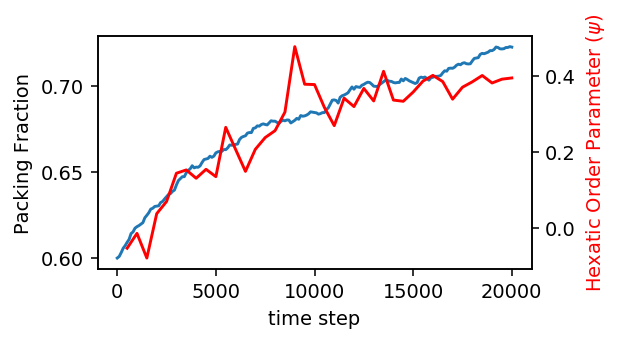

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import gsd.hoomd
%matplotlib inline

with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    N = traj[-1].particles.N
# alternately, use a custom log operation to log phi directly

log = np.genfromtxt(fname=JOB.fn('log.dat'), names=True)
psi = np.load(JOB.fn('order.npz'))

fig, ax = plt.subplots(figsize=(4, 2.2), dpi=140)
ax2 = ax.twinx()

ax.plot(log['timestep'], N * JOB.doc.poly_area / log['volume'])
ax.set_xlabel('time step')
ax.set_ylabel('Packing Fraction')

ax2.plot(psi['steps'], np.real(psi['psi']).mean(axis=1), color='red')
ax2.set_ylabel('Hexatic Order Parameter ($\psi$)', color='red')

plt.show()

# Additional Analyses

## Simple visualization

In [4]:
def quat2ang(quats):
    """Convert quaternions to angles."""
    return np.mod(2*np.arctan2(quats[:, 3], quats[:, 0]), 2*np.pi)

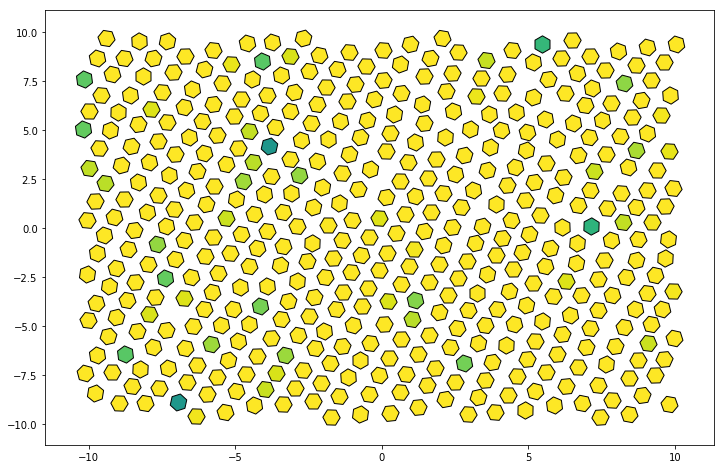

In [5]:
plt.figure(figsize=(12, 8))
with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    frame = traj[-1]
    z = zip(frame.particles.position, quat2ang(frame.particles.orientation))
    for p, ang in z:
        plt.scatter(p[0], p[1], marker=(6, 0, np.rad2deg(ang)+45),
                    edgecolor='k', c=ang, vmin=-np.pi/4, vmax=np.pi/4, s=300)

## PMFT

In [6]:
import freud

pmfts = []
with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    for frame in [traj[1], traj[-1]]:
        box = freud.box.Box.from_box(frame.configuration.box[:2])
        pmft = freud.pmft.PMFTXY2D(4, 4, 300, 300)
        pmft.compute(box, frame.particles.position, quat2ang(frame.particles.orientation))
        pmfts.append(pmft)

/home/vramasub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


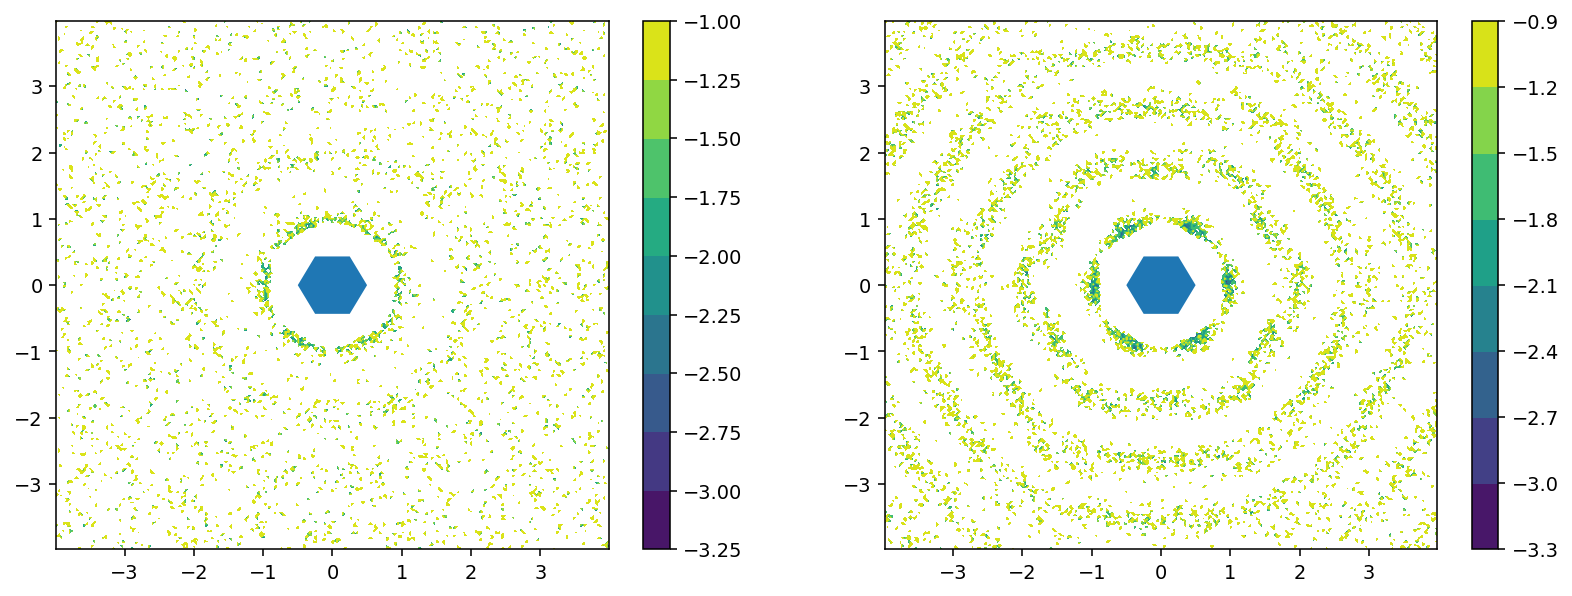

In [7]:
from matplotlib import patches
import geometry

fig, axes = plt.subplots(1, len(pmfts), figsize=(14, 5), dpi=140)
for ax, pmft in zip(np.atleast_1d(np.array(axes)), pmfts):
    im = ax.contourf(pmft.X, pmft.Y, pmft.PMFT.T)
    fig.colorbar(im, ax=ax)
    ax.add_patch(patches.Polygon(xy=geometry.get_vertices(6)))

## RDF

In [8]:
rdfs = []
with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    for frame in [traj[1], traj[-1]]:
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        rdf = freud.density.RDF(np.sqrt(box.Lx**2 + box.Ly**2)/5, box.Lx/1000)
        rdf.compute(box, frame.particles.position)
        rdfs.append(rdf)

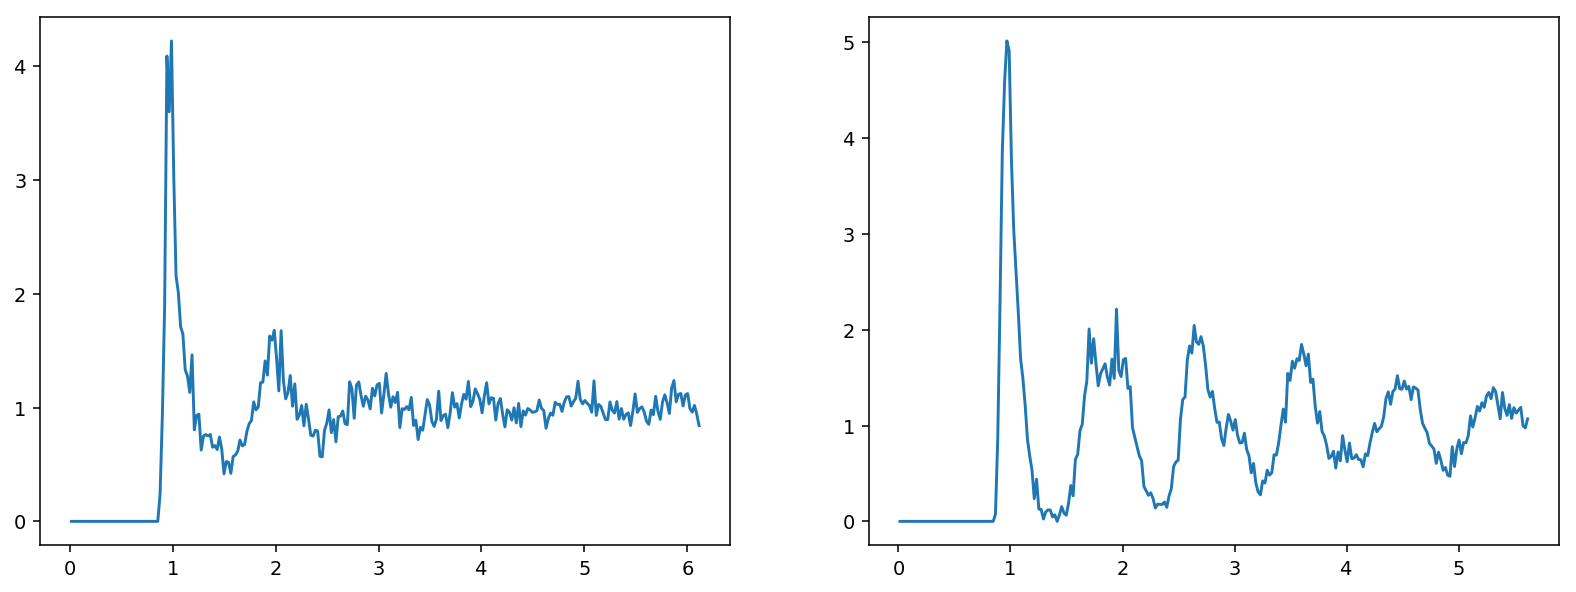

In [9]:
fig, axes = plt.subplots(1, len(rdfs), figsize=(14, 5), dpi=140)
for ax, rdf in zip(np.atleast_1d(np.array(axes)), rdfs):
    rdf_values = rdf.RDF.copy()
    ax.plot(rdf.R, rdf_values)

## Voronoi

In [10]:
voronois = []
with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    for frame in [traj[1], traj[-1]]:
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        voronoi = freud.voronoi.Voronoi(box, np.sqrt(box.Lx**2 + box.Ly**2)/5)
        voronoi.compute(frame.particles.position, box)
        voronois.append(voronoi)

In [11]:
from matplotlib import collections
def draw_voronoi(ax, box, cells):
    # Number
    colors = [len(cell) for cell in cells]
    
    # Draw Voronoi cells
    patches = [plt.Polygon(cell[:, :2]) for cell in cells]
    patch_collection = collections.PatchCollection(patches, edgecolors='black')
    patch_collection.set_array(np.array(colors))
    ax.add_collection(patch_collection)

    # Draw points
    ax.set_xlim((-box.Lx/2, box.Lx/2))
    ax.set_ylim((-box.Ly/2, box.Ly/2))
    
    # Show colorbar for number of sides
    fig.colorbar(patch_collection, ax=ax)

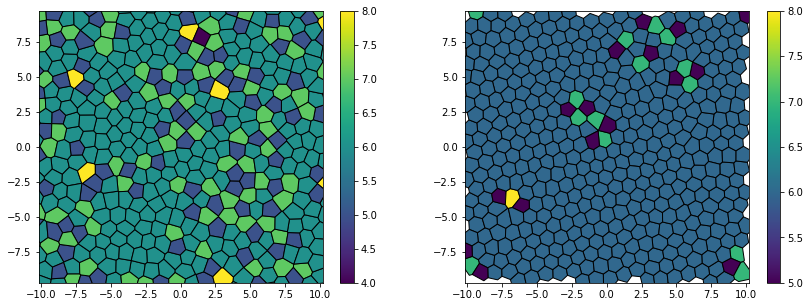

In [12]:
fig, axes = plt.subplots(1, len(voronois), figsize=(14, 5))
for ax, voro in zip(np.atleast_1d(np.array(axes)), voronois):
    draw_voronoi(ax, box, voro.polytopes)

## Unified

In [13]:
from matplotlib import collections

def quat2ang(quats):
    """Convert quaternions to angles."""
    return np.mod(2*np.arctan2(quats[:, 3], quats[:, 0]), 2*np.pi)

def draw_pmft(ax, pmft, nverts):
    im = ax.contourf(pmft.X, pmft.Y, pmft.PMFT.T)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label("$k_b T$", fontsize=12)
    ax.add_patch(patches.Polygon(xy=geometry.get_vertices(nverts)))

def draw_voronoi(ax, box, cells):
    """Draw voronoi tesselation"""
    colors = [len(cell) for cell in cells]
    patches = [plt.Polygon(cell[:, :2]) for cell in cells]
    patch_collection = collections.PatchCollection(patches, edgecolors='black')
    patch_collection.set_array(np.array(colors))
    ax.add_collection(patch_collection)
    ax.set_xlim((-box.Lx/2, box.Lx/2))
    ax.set_ylim((-box.Ly/2, box.Ly/2))
    cb = fig.colorbar(patch_collection, ax=ax)
    cb.set_label("Number of sides", fontsize=12)

In [14]:
pmfts = []
rdfs = []
voronois = []

with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    for frame in [traj[1], traj[-1]]:
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        voronoi = freud.voronoi.Voronoi(box, np.sqrt(box.Lx**2 + box.Ly**2)/5)
        voronoi.compute(frame.particles.position, box)
        voronois.append(voronoi)
        
        rdf = freud.density.RDF(np.sqrt(box.Lx**2 + box.Ly**2)/5, box.Lx/1000)
        rdf.compute(box, frame.particles.position)
        rdfs.append(rdf)
        
        pmft = freud.pmft.PMFTXY2D(4, 4, 300, 300)
        pmft.compute(box, frame.particles.position, quat2ang(frame.particles.orientation))
        pmfts.append(pmft)

/home/vramasub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


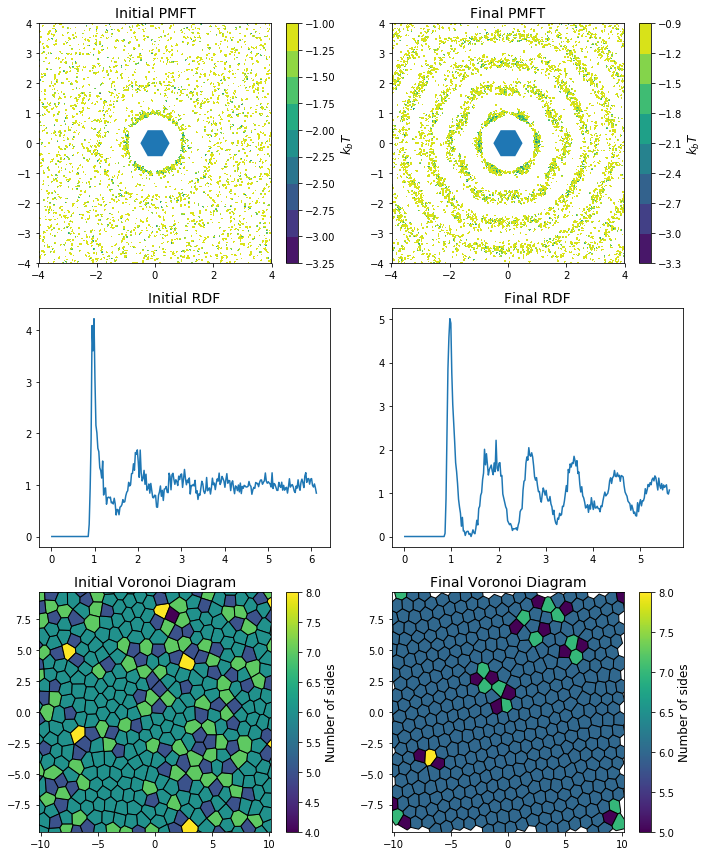

In [15]:
fig, axes = plt.subplots(3, len(voronois), figsize=(10, 12))
titles = ["Initial", "Final"]

for ax, title, pmft, rdf, voro in zip(axes.T, titles, pmfts, rdfs, voronois):
    draw_pmft(ax[0], pmft, JOB.sp.n)
    ax[0].set_title(title + " PMFT", fontsize=14)

    ax[1].plot(rdf.R, rdf.RDF)
    ax[1].set_title(title + " RDF", fontsize=14)

    draw_voronoi(ax[2], box, voro.polytopes)
    ax[2].set_title(title + " Voronoi Diagram", fontsize=14)
fig.tight_layout()